In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('data/airfoil_self_noise/airfoil_self_noise.dat',sep="\t",header=None)

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

In [3]:
df.head()

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [4]:
df.columns=["freq","attack_angle","chord_len","fs_velocity","suc_side","press_lev"]

In [5]:
df.head()

,freq,attack_angle,chord_len,fs_velocity,suc_side,press_lev
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
df.isnull().sum()

freq            0
attack_angle    0
chord_len       0
fs_velocity     0
suc_side        0
press_lev       0
dtype: int64

In [7]:
[feat for feat in df.iloc[:,:-1].columns][0]

'freq'

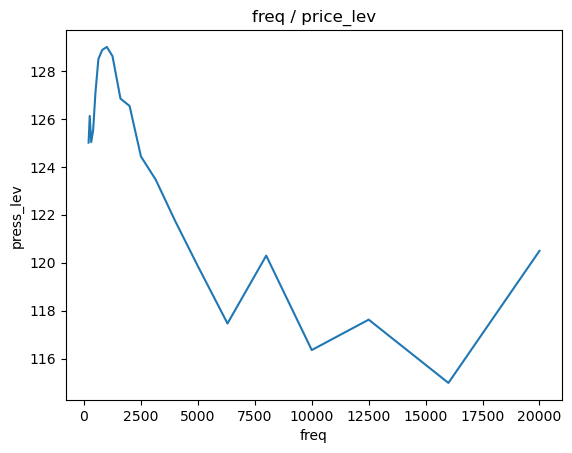

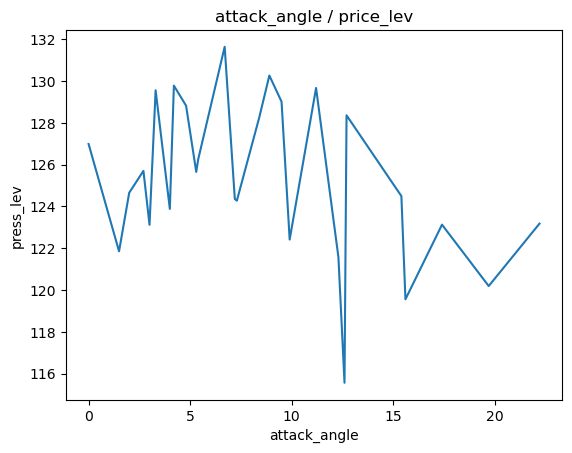

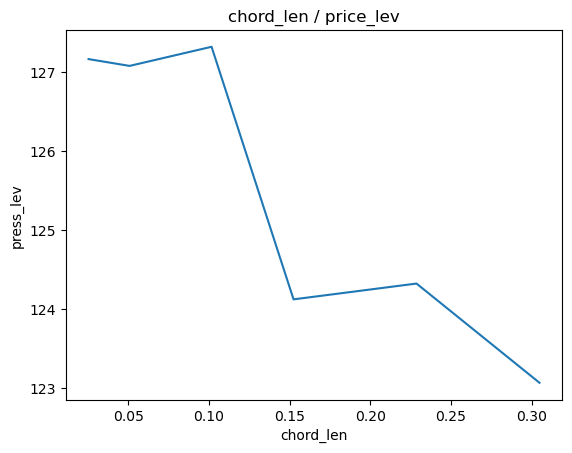

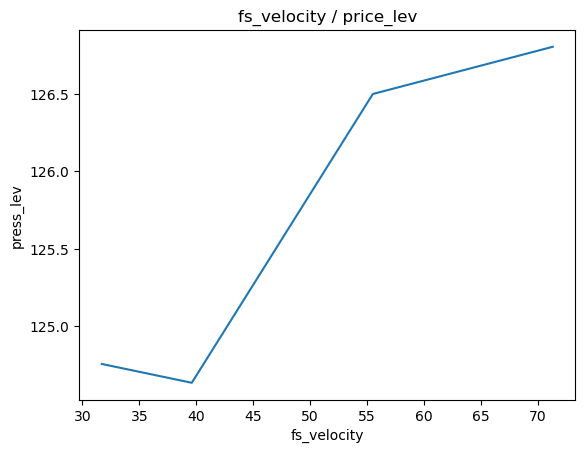

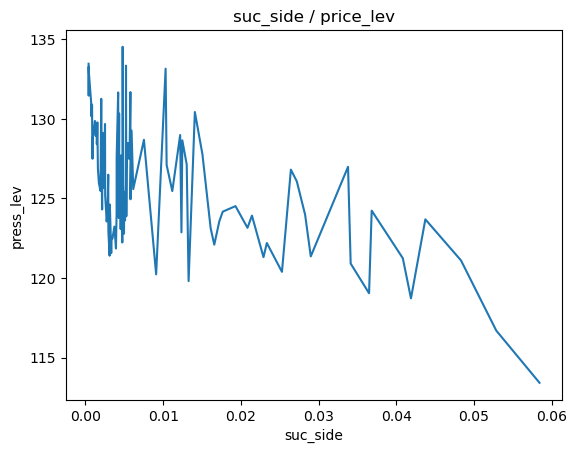

In [8]:
import matplotlib.pyplot as plt
pred_feats = [feat for feat in df.iloc[:,:-1]]
for i in range(len(df.iloc[:,:-1].columns)):
    df.groupby(pred_feats[i])['press_lev'].median().plot()
    plt.xlabel(pred_feats[i])
    plt.ylabel('press_lev')
    plt.title(pred_feats[i]+' / price_lev')
    plt.show()

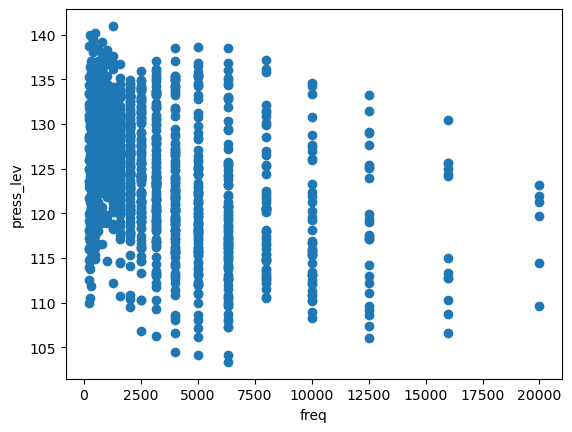

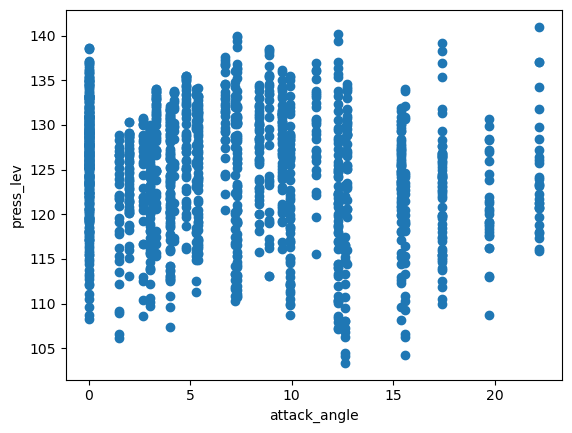

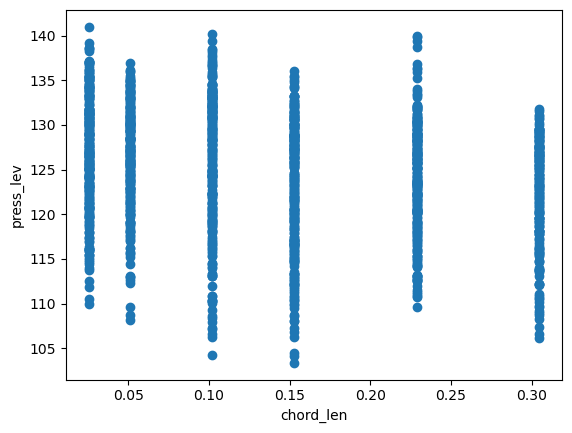

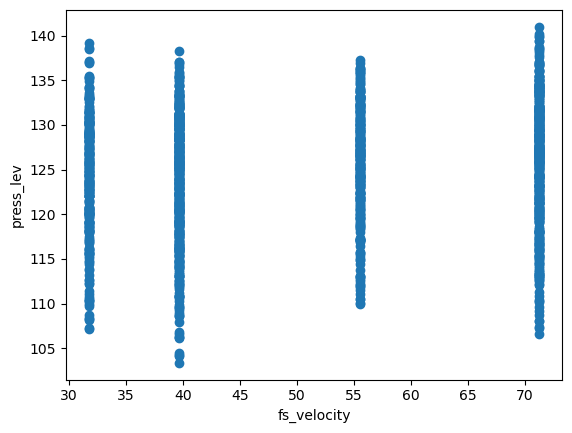

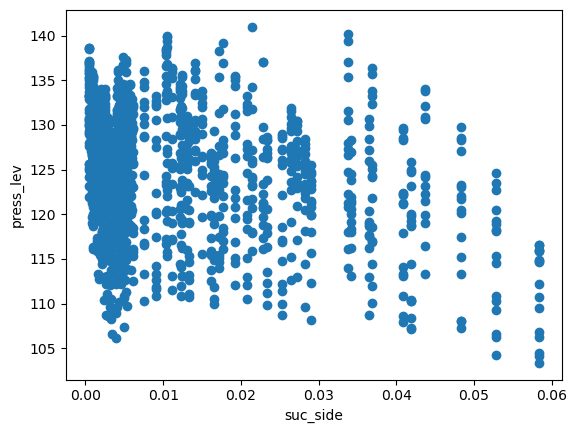

In [9]:
for feature in pred_feats:
    if feature != 'press_lev':

        plt.scatter(df[feature], df['press_lev'])
        plt.xlabel(feature)
        plt.ylabel('press_lev')
        plt.show()

In [10]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [11]:
### train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [12]:
X_train.head()

,freq,attack_angle,chord_len,fs_velocity,suc_side
845,500,11.2,0.0508,71.3,0.014072
1026,10000,4.8,0.0254,55.5,0.000873
621,2000,7.2,0.1524,39.6,0.009092
1371,630,6.7,0.1016,31.7,0.005929
195,6300,0.0,0.2286,71.3,0.002143


In [13]:
import matplotlib.pyplot as plt

corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,freq,attack_angle,chord_len,fs_velocity,suc_side
freq,1.000000,-0.273327,-0.000324,0.125247,-0.239878
attack_angle,-0.273327,1.000000,-0.498257,0.058603,0.762567
chord_len,-0.000324,-0.498257,1.000000,0.013061,-0.220849
fs_velocity,0.125247,0.058603,0.013061,1.000000,-0.000519
suc_side,-0.239878,0.762567,-0.220849,-0.000519,1.000000


/Users/lecha/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


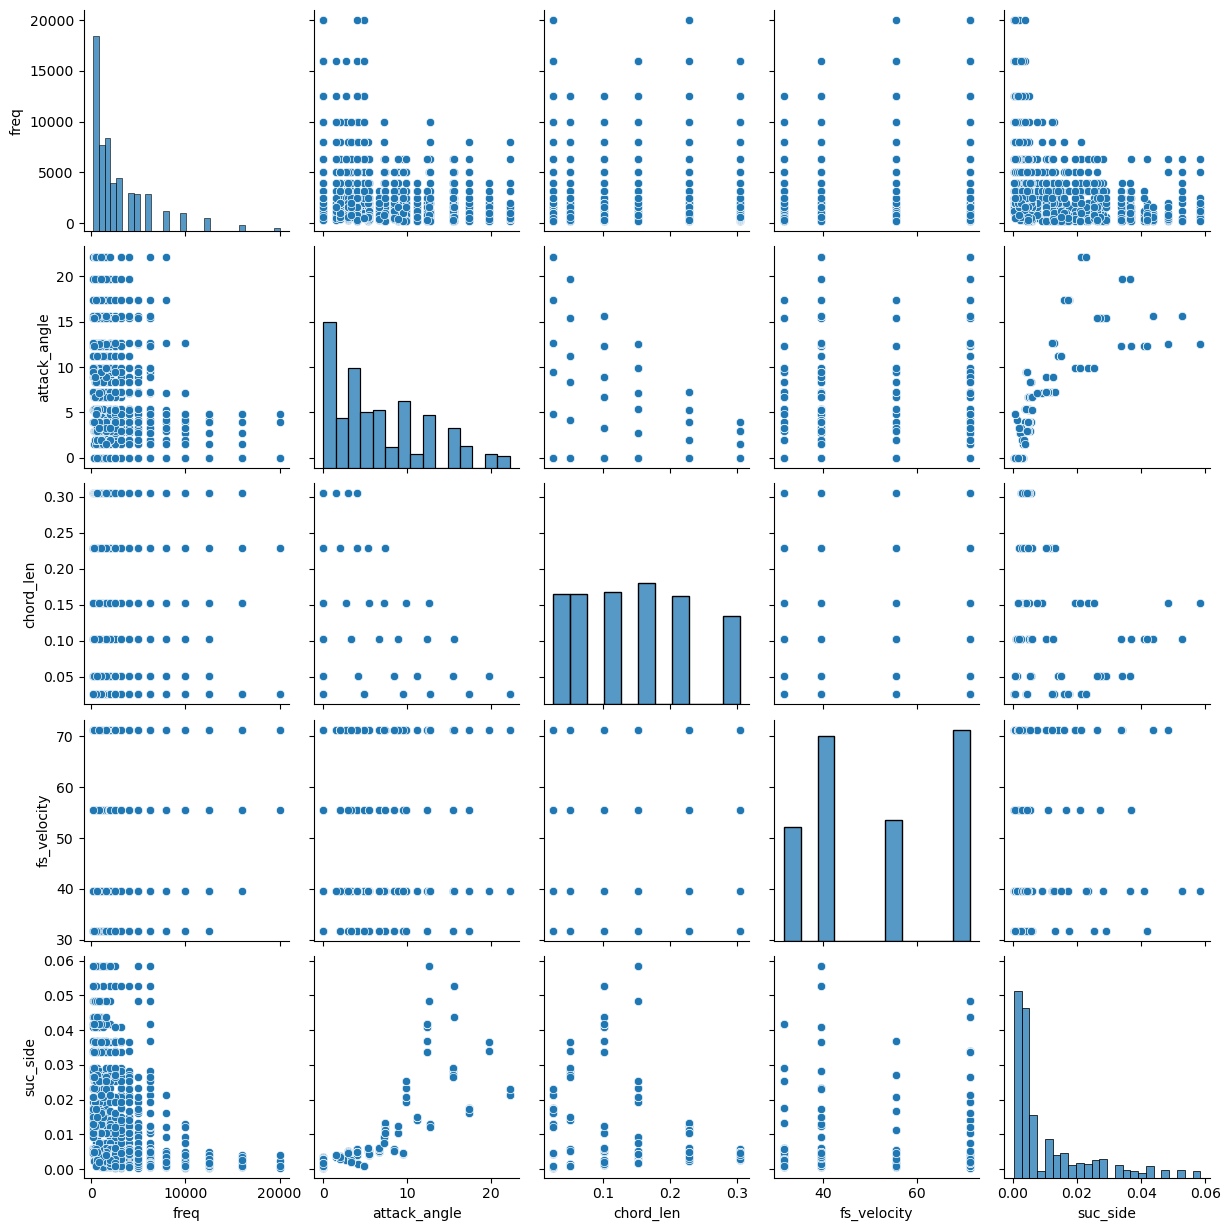

In [14]:
import seaborn as sns
sns.pairplot(X_train)

<Axes: >

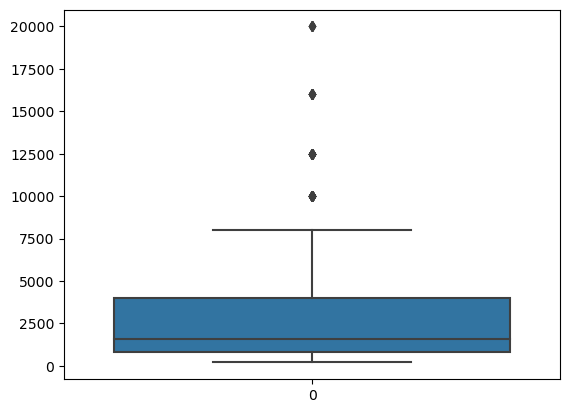

In [15]:
sns.boxplot(X_train['freq'])

In [16]:
len(df['press_lev'].unique())

1456

<Axes: >

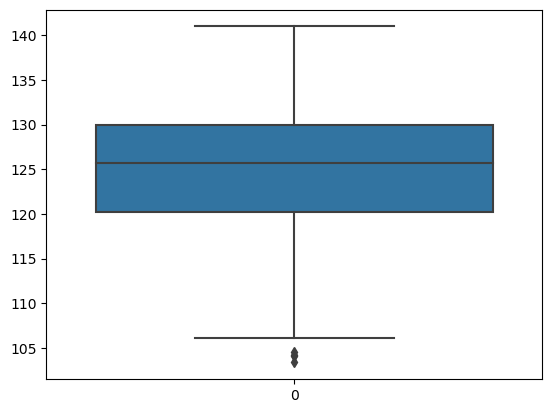

In [17]:
sns.boxplot(df['press_lev'])

/Users/lecha/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


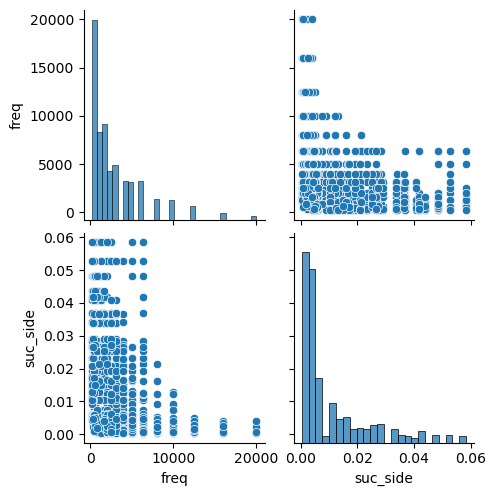

In [18]:
sns.pairplot(X_train.loc[:,['freq','suc_side']])

/Users/lecha/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


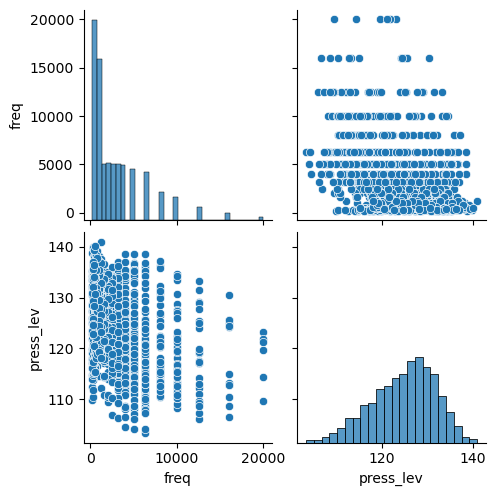

In [19]:
sns.pairplot(df.loc[:, ['freq','press_lev']])

In [20]:
# number of unique target values
if len(df['press_lev'])>=20:
    problem = "Regression"
else:
    problem = "Classification"
print("Since number of unique values of target is {}, \nwe are dealing with {} problem".format(len(df['press_lev']), problem))

Since number of unique values of target is 1503, 
we are dealing with Regression problem


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

X = df.drop(columns=["press_lev"])
y = df["press_lev"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=["float64"]).columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])

param_grid = {
    "Linear Regression": {},
    "Ridge Regression": {"model__alpha": [0.1, 1.0, 10.0]},
    "Decision Tree Regressor": {"model__max_depth": [None, 10, 20]}
}

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree Regressor": DecisionTreeRegressor()
    
}

best_models = {}
best_mse = float('inf')

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    grid_search = GridSearchCV(pipeline, param_grid[name], scoring="neg_mean_squared_error", cv=5)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    y_pred = best_models[name].predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - Best MSE: {mse:.2f}, Best Params: {grid_search.best_params_}")
    
    if mse < best_mse:
        best_model_name = name
        best_params = grid_search.best_params_
        best_mse = mse

print(f"The best model is {best_model_name} with MSE of {best_mse:.2f} and best parameters: {best_params}")


Linear Regression - Best MSE: 35.87, Best Params: {}
Ridge Regression - Best MSE: 35.91, Best Params: {'model__alpha': 10.0}
Decision Tree Regressor - Best MSE: 39.19, Best Params: {'model__max_depth': 20}
The best model is Linear Regression with MSE of 35.87 and best parameters: {}


In [22]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [23]:
import pickle
pickle.dump(regressor, open('models/0528_model.pkl', 'wb'))

In [24]:
pickled_model = pickle.load(open('models/0528_model.pkl', 'rb'))
pickled_model.predict(X_test)

array([124.16191238, 119.71754202, 120.29668459, 129.615236  ,
       129.75593826, 132.44661903, 122.32665515, 126.58759234,
       129.7891252 , 125.87270144, 132.50284725, 113.82497485,
       129.75962929, 132.1698327 , 123.53815285, 114.21607079,
       124.25507057, 126.57081225, 129.14909599, 131.54463756,
       125.80371357, 124.94914381, 116.48582553, 129.78494777,
       124.07338609, 124.69532637, 131.47376661, 124.50941128,
       115.86928543, 123.33774182, 124.80593366, 123.87075426,
       125.38176942, 118.39568682, 121.61056106, 130.71601949,
       131.37249464, 128.13054816, 120.99082297, 118.12791256,
       126.2802011 , 128.66877533, 126.28802038, 123.344018  ,
       123.07535688, 129.94047889, 124.90957915, 119.82276489,
       123.1325163 , 132.57358723, 128.74819037, 117.76248837,
       123.29035336, 122.59000264, 126.66441332, 120.15474596,
       123.3734213 , 128.636308  , 124.35266792, 123.10094219,
       125.39270976, 131.02764182, 126.66115765, 131.08